In [1]:
import sys
sys.path.append("network/hvae")

from torch.nn.functional import interpolate
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms as T
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from network.hvae.oodd.losses import ELBO
import os
import typing as t
import gzip
import torch
import surprisenet.packnet as pn
from surprisenet.task_inference import TaskInferenceStrategy
from network.deep_vae import FashionMNISTDeepVAE
from tqdm import tqdm



plt.rcParams.update(
    {
        'font.family': 'Alegreya Sans',
        'font.size': 12,
        "image.cmap": "cividis"
    }
)


elbo_loss_func = ELBO()
MODEL_FILENAME = "/home/antonlee/github.com/tachyonicClock/SurpriseNetRun/SurpriseNet/experiment_logs/0002_sweet-release.ecs.vuw.ac.nz_5663eb3fD_myExperiment_S-FMNIST_DeepVAE_surpriseNet/model.pt.gz"
ROOT="/local/scratch/antonlee/datasets/"
TASK_COMP = [
    [8,1],
    [9,4],
    [3,5],
    [2,7],
    [0,6],
]

In [2]:
# Load Model
from surprisenet.task_inference import HierarchicalVAEOOD

model = pn.SurpriseNetDeepVAE(FashionMNISTDeepVAE(), HierarchicalVAEOOD(k=2))
with gzip.open(MODEL_FILENAME, "rb") as f:
    model.load_state_dict(torch.load(f))


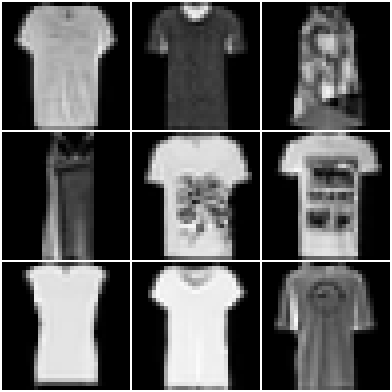

In [3]:
# Setup Dataset
def split_by_class(dataset: Dataset) -> t.List[Dataset]:
    """Split a dataset into a list of datasets, where each dataset contains only
    one class.
    """
    classes = set(map(int, dataset.targets))
    datasets = []
    for y in classes:
        indices = torch.where(dataset.targets == y)[0]
        datasets.append(Subset(dataset, indices))
    return datasets

def random_batch(dataset: Dataset, batch_size: int) -> t.Tuple[torch.Tensor, torch.Tensor]:
    """Return a random batch of `batch_size` from `dataset`
    """
    indices = torch.randperm(len(dataset))[:batch_size]
    x = torch.stack([dataset[i][0] for i in indices])
    y = torch.tensor([dataset[i][1] for i in indices])
    return x, y

def display_batch(x: torch.Tensor, scale: float = 4.0, rows: int = 3):
    """Display a batch of images in a grid
    """
    x = interpolate(x, scale_factor=scale, mode="nearest")
    image_grid = make_grid(x, nrow=rows, pad_value=1.0)
    return to_pil_image(image_grid)
    
transform = T.Compose([
    T.ToTensor(),
    T.Resize((32, 32)),
])

joint_dataset = FashionMNIST(ROOT, train=False, transform=transform)
test_sets = split_by_class(joint_dataset)
display_batch(random_batch(test_sets[0], 9)[0])

In [14]:
# model.eval()

# x, _ = random_batch(test_sets[0], 9)
# model.use_task_subset(0)

# samples = []
# for i in range(6):
#     likelihood, stage_data = model.wrapped.forward(x)
#     samples.append(likelihood.samples)

# samples = torch.cat(samples)
# display_batch(samples, rows=9)


In [103]:
from sklearn.manifold import TSNE

model.eval()
model.cuda()

active_task = 1
model.use_task_subset(active_task)




dataloader = DataLoader(joint_dataset, batch_size=100, shuffle=False)

# mean_stage_0 = []
# means_stage_1 = []
z_stage = []
with torch.no_grad():
    for x, y in tqdm(dataloader):
        x = x.cuda()
        likelihood, stage_data = model.wrapped.forward(x)

        # mean_stage_0.append(stage_data[0].q.mean)
        # means_stage_1.append(stage_data[1].q.mean)
        z_stage.append(stage_data[0].q.z)


# mean_stage_0 = torch.cat(mean_stage_0)
# means_stage_1 = torch.cat(means_stage_1)
z_stage = torch.cat(z_stage)


100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


In [104]:
z_stage.shape

torch.Size([10000, 8, 16, 16])

In [105]:
# t-sne
tsne = TSNE(n_components=2, random_state=0)
print("Fitting t-sne")
numpy_z = z_stage.flatten(start_dim=1).detach().cpu().numpy()
z_2d = tsne.fit_transform(numpy_z)

Fitting t-sne


Text(0.5, 1.0, 't-sne Z (k=2) subset 1 just saw [9, 4]')

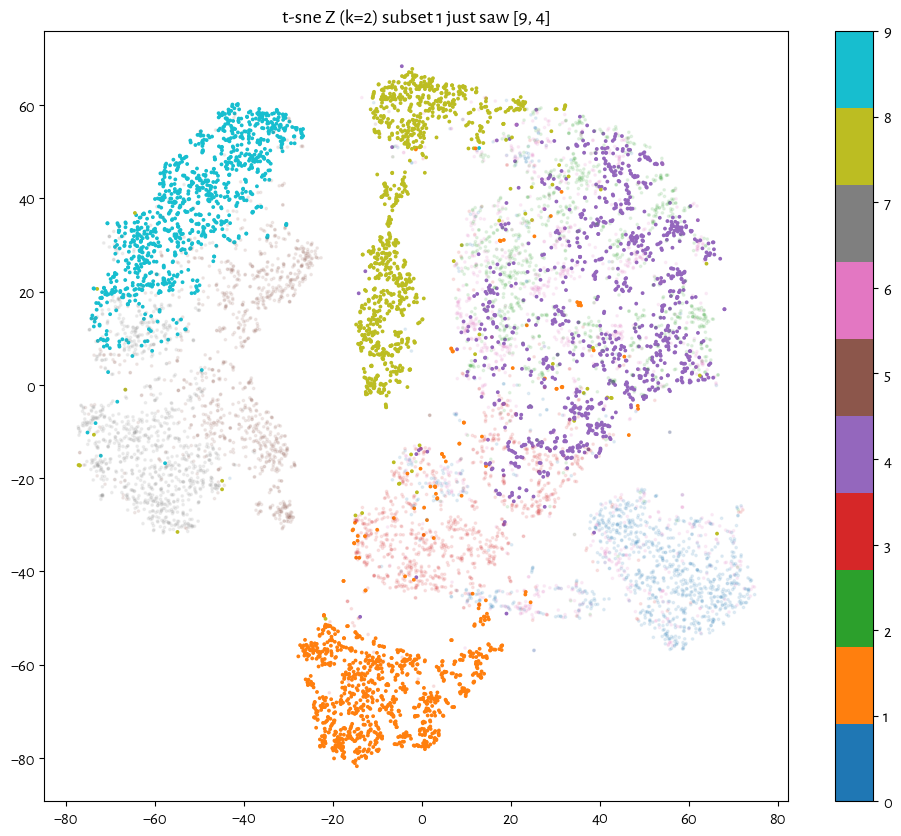

In [106]:
# plot
plt.figure(figsize=(12, 10))

seen_indices = torch.tensor([], dtype=torch.long)
for composition in TASK_COMP[:active_task+1]:
    for class_label in composition:
        seen_indices = torch.cat([seen_indices, torch.where(joint_dataset.targets == class_label)[0]])

# seen_indices to determine alpha
alpha = torch.ones(len(joint_dataset)) * 0.1
alpha[seen_indices] = 1.0



plt.scatter(
    z_2d[:, 0], z_2d[:, 1], 
    c=joint_dataset.targets,
    alpha=alpha,
    cmap="tab10",
    s=3.0)
plt.colorbar()
plt.title(f"t-sne Z (k=2) subset {active_task} just saw {TASK_COMP[active_task]}")

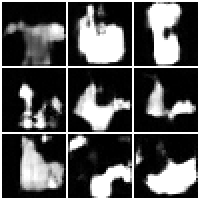

In [6]:
model.eval()
model.use_task_subset(4)
display_batch(model.generate(9), scale=2)

In [7]:
x, _ = random_batch(test_sets[0], 10)

In [8]:

model.eval()

def _kl_divergences_from_stage(stage_datas: t.List[pn.StageData]):
    return [
        stage_data.loss.kl_elementwise
        for stage_data in stage_datas
        if stage_data.loss.kl_elementwise is not None
    ]

def get_decode_from_p(n_latents, k=0, semantic_k=True):
    """
    k semantic out
    0 True     [False, False, False]
    1 True     [True, False, False]
    2 True     [True, True, False]
    0 False    [True, True, True]
    1 False    [False, True, True]
    2 False    [False, False, True]
    """
    if semantic_k:
        return [True] * k + [False] * (n_latents - k)

    return [False] * (k + 1) + [True] * (n_latents - k - 1)


@torch.no_grad()
def novelty_score(model: pn.SurpriseNetDeepVAE, x: torch.Tensor) -> torch.Tensor:
    model.eval()

    # Regular ELBO
    likelihood_data, stage_data = model(x)
    _, elbo, _, _ = elbo_loss_func(
        likelihood_data.likelihood,
        _kl_divergences_from_stage(stage_data),
        samples=1,
        free_nats=0,
        beta=1,
        sample_reduction=None,
        batch_reduction=None,
    )

    # L>k bound
    latent_hierarchy_depth = model.wrapped.deep_vae.n_latents
    decode_from_p = get_decode_from_p(latent_hierarchy_depth, k=2)
    likelihood_data, stage_data = model.wrapped(x, decode_from_p=decode_from_p, use_mode=decode_from_p)
    _, elbo_k, _, _ = elbo_loss_func(
        likelihood_data.likelihood,
        _kl_divergences_from_stage(stage_data),
        samples=1,
        free_nats=0,
        beta=1,
        sample_reduction=None,
        batch_reduction=None,
    )

    return elbo - elbo_k



model.cuda()
for task in range(5):
    model.use_task_subset(task)
    for i, dataset in enumerate(test_sets):
        x, y = random_batch(dataset, 50)
        x = x.cuda()
        novelty_scores = model.task_inference_strategy._novelty_score(x)
        
        
        print(f"t:{task} {novelty_scores.min():.2f} {novelty_scores.mean():.2f}")

    print()
        # print(f"Novelty score for {i}: {novelty_scores.mean():.2f} ± {novelty_scores.std():.2f}")


t:0 2509.58 5840.95
t:0 781.92 1968.91
t:0 4187.40 6728.01
t:0 1788.72 4347.93
t:0 3348.43 5740.65
t:0 1935.61 3296.59
t:0 2218.23 6142.97
t:0 2155.82 3229.67
t:0 1350.05 4700.71
t:0 3248.90 5311.98

t:1 3526.06 6248.36
t:1 2835.10 3941.24
t:1 2971.20 5356.11
t:1 2752.12 4308.60
t:1 2379.56 4955.81
t:1 2490.26 3990.08
t:1 3529.67 5696.69
t:1 2310.48 3056.36
t:1 3736.58 6423.22
t:1 1937.47 4057.88

t:2 3564.97 5257.27
t:2 2274.23 3950.65
t:2 4268.18 7028.71
t:2 2078.57 3840.14
t:2 3718.23 6716.13
t:2 1139.27 2866.45
t:2 3364.18 6160.15
t:2 1767.91 3139.50
t:2 2810.72 6631.88
t:2 2661.81 4935.56

t:3 2817.74 5989.15
t:3 2661.49 4486.93
t:3 3059.64 5291.96
t:3 2818.66 4302.59
t:3 3599.67 5134.34
t:3 1948.53 3969.37
t:3 3191.60 5731.07
t:3 1525.81 2766.15
t:3 4137.00 7071.99
t:3 2273.92 4502.57

t:4 1641.45 4524.29
t:4 3086.64 3978.40
t:4 3333.77 5659.17
t:4 2500.50 4193.60
t:4 3898.39 5470.47
t:4 1645.68 4274.98
t:4 2253.62 5064.60
t:4 2955.86 4126.42
t:4 4151.28 6981.84
t:4 3558.09 6291.

In [9]:


# model.use_task_subset(0)
# decode_from_p = get_decode_from_p(3, k=1)
# print(decode_from_p)
# likelihood_data, stage_data = model(x, decode_from_p=decode_from_p, use_mode=decode_from_p)

# samples = likelihood_data.samples
# interleaved_samples = torch.stack([x, samples], dim=1).reshape(-1, *x.shape[1:])

# print(likelihood_data.likelihood)

# display_batch(interleaved_samples, rows=6, scale=2)

In [5]:
from tqdm import tqdm
model.cuda()
model.eval()

class_task_count = torch.zeros(10, 5)

with torch.no_grad():
    for class_label, test_set in enumerate(test_sets):
        dataloader = DataLoader(test_set, batch_size=100, shuffle=False)

        print("Testing on class", class_label)
        for x, y in tqdm(dataloader):
            x = x.cuda()
            out = model.multi_forward(x)
            for subset_pred in out.pred_exp_id:
                class_task_count[class_label, subset_pred] += 1


Testing on class 0


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Testing on class 1


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Testing on class 2


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Testing on class 3


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Testing on class 4


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Testing on class 5


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Testing on class 6


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Testing on class 7


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Testing on class 8


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Testing on class 9


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


In [10]:
task_confusion = torch.zeros(5, 5)

for true_task, composition in enumerate(TASK_COMP):
    for class_label in composition:
        task_confusion[true_task] += class_task_count[class_label]
task_confusion

tensor([[1775.,   37.,   70.,   87.,   31.],
        [  66., 1298.,   96.,  391.,  149.],
        [ 275.,  128., 1286.,  159.,  152.],
        [  46.,  392.,   82., 1287.,  193.],
        [ 165.,  278.,  266.,  198., 1093.]])

tensor(0.6739)

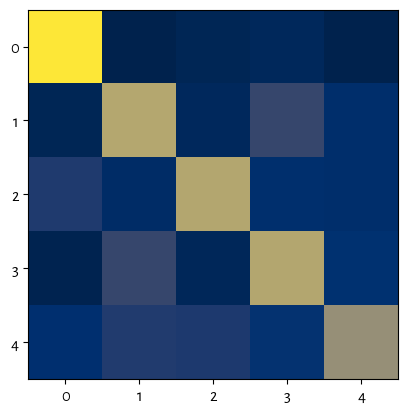

In [11]:


plt.imshow(task_confusion)

# What percentage lies on the diagonal?
task_confusion.diag().sum() / task_confusion.sum()